# Tests

Purpose:
- Explore for simple correlatd and uncorrelated scenarios under what circumstances the correct posteriors can be reproduced
- Demonstrate how this can be done with **minimum effort** and **small feedback loop**

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
DEVICE = 'cuda:0'

In [28]:
zdim = 10
param_names = ["z"+str(i) for i in range(zdim)]

### Test 1 - Small signal, huge noise, large data, more training data

In [114]:
g = np.linspace(-np.pi, np.pi, 100)
T = np.array([
    np.sin(g),
    np.cos(g),
    np.sin(g*1.3),
    np.cos(g*1.3),
    np.sin(g*2),
    np.cos(g*2),
    np.sin(g*3),
    np.cos(g*3),
    np.sin(g*4),
    np.cos(g*4),
]).T
#T = T[:,0:5]
sigma = 0.4
F = T.T.dot(T)/sigma**2
#plt.imshow(F)
Sigma = np.linalg.inv(F)
errors0 = np.diag(Sigma)**0.5
errors1 = np.diag(1/F)**0.5

C = np.diag(1/errors0).dot(Sigma.dot(np.diag(1/errors0)))
#plt.imshow(C)
#plt.colorbar()
print(errors0)
#print(errors1)
print(errors0/errors1)

[0.1640216  0.20282698 0.20607097 0.20066963 0.10799614 0.08086938
 0.0715558  0.05920295 0.06406257 0.05707581]
[2.88498554 3.60339126 3.43295564 3.7406164  1.89955053 1.43671231
 1.25859913 1.05178993 1.12680028 1.0139996 ]


In [36]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [37]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [61]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs1 = noise(obs0, par0)

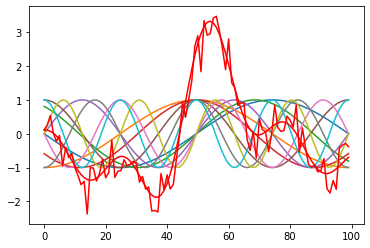

In [62]:
plt.plot(T);
plt.plot(obs0['x'], 'r')
plt.plot(obs1['x'], 'r')

In [40]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [41]:
class Head(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = 50
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([10000]))
        self.l1 = torch.nn.Linear(10000, 50)
        
    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        x = self.l1(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `Head`


In [50]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 20000)

In [51]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (100,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 20000


Creating new cache.


INFO:root:Additional simulations are required after growing the cache.
Simulate: 100%|██████████| 20118/20118 [01:25<00:00, 236.41it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([100])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(100, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.0

  adding 20118 new samples to simulator cache.


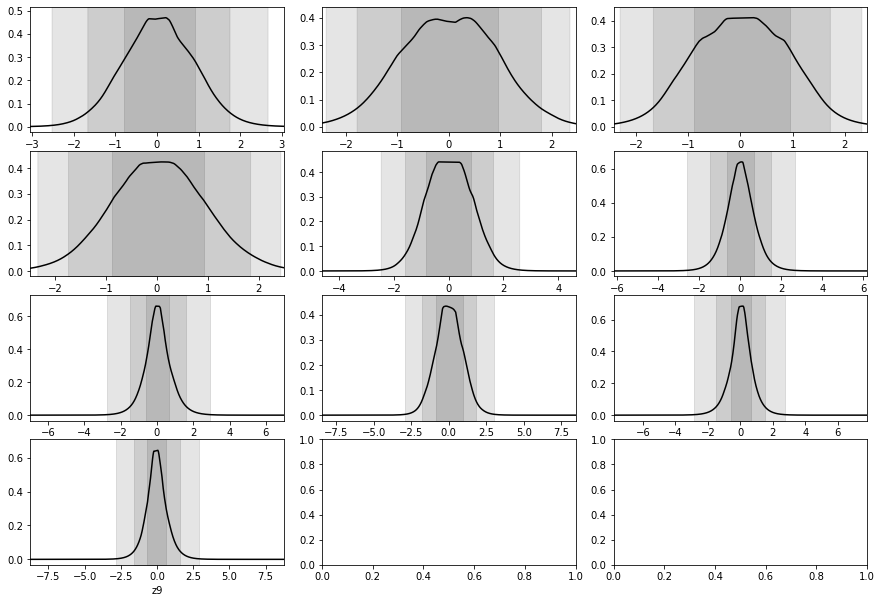

In [54]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]
swyft.plot1d(samples, param_names, ncol = 3, grid_interpolate = True)

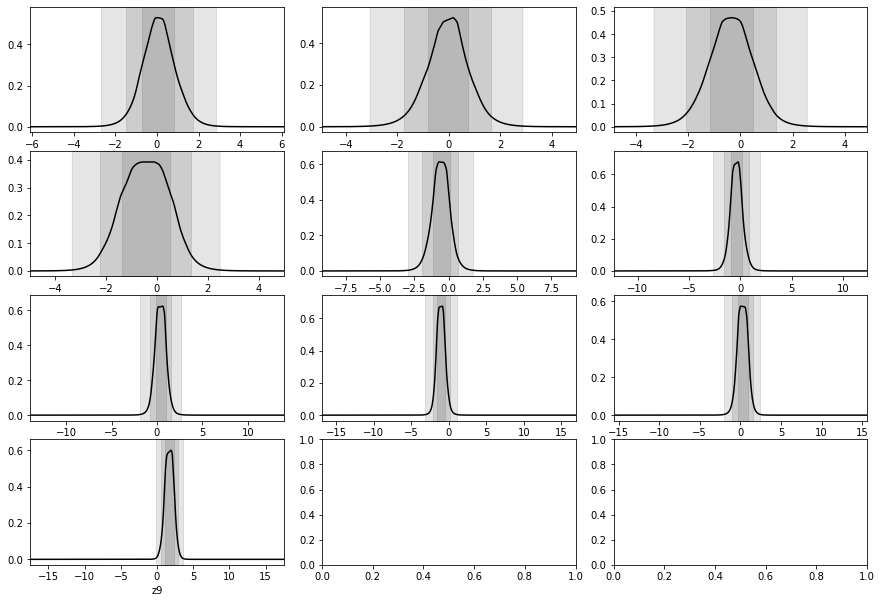

In [126]:
samples = s.marginals(obs1, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]
swyft.plot1d(samples, param_names, ncol = 3, grid_interpolate = True)

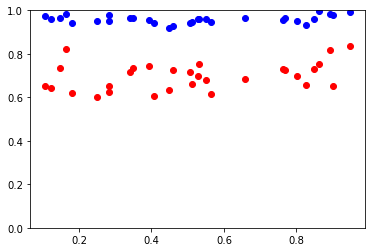

In [113]:
for i in range(3):
    #indices = s.cache.sample(prior, 10)[]
    indices = [i,]
    points = swyft.Points(indices, s.cache, noisehook = noise)
    c = swyft.utils.estimate_coverage(s.marginals, points, nrounds = 1000)
    p = [points[0]['par'][k] for k in param_names]
    l = np.array([[c[k][j] for k in param_names] for j in range(3)])
    #print(c)
    #print("  ")
    plt.scatter(p, l[0], color='r')
    plt.scatter(p, l[1], color='b')
    plt.ylim([0, 1])

### Conclusions

- Network *seems* overconfident, since the inferred errors are smaller than what is predicted by Fisher forcasting.
- Still, coverage looks aout fine, and also Asimov vs noisy data doesn't make a difference
- Presumaby this is caused by the fact that we do significantly cut into the tails of some of the distributions, which might affect all distriutions through their strong correlations
- Way to test this is to make errors smaller

### Test 2 - Small signal, huge noise, large data, more training data - smaller errors

- Errors are now within 5 sigma range

In [116]:
g = np.linspace(-np.pi, np.pi, 100)
T = np.array([
    np.sin(g),
    np.cos(g),
    np.sin(g*1.3),
    np.cos(g*1.3),
    np.sin(g*2),
    np.cos(g*2),
    np.sin(g*3),
    np.cos(g*3),
    np.sin(g*4),
    np.cos(g*4),
]).T
#T = T[:,0:5]
sigma = 0.2
F = T.T.dot(T)/sigma**2
#plt.imshow(F)
Sigma = np.linalg.inv(F)
errors0 = np.diag(Sigma)**0.5
errors1 = np.diag(1/F)**0.5

C = np.diag(1/errors0).dot(Sigma.dot(np.diag(1/errors0)))
#plt.imshow(C)
#plt.colorbar()
print(errors0)
#print(errors1)
print(errors0/errors1)

[0.0820108  0.10141349 0.10303548 0.10033481 0.05399807 0.04043469
 0.0357779  0.02960147 0.03203128 0.02853791]
[2.88498554 3.60339126 3.43295564 3.7406164  1.89955053 1.43671231
 1.25859913 1.05178993 1.12680028 1.0139996 ]


In [117]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [118]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [119]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs1 = noise(obs0, par0)

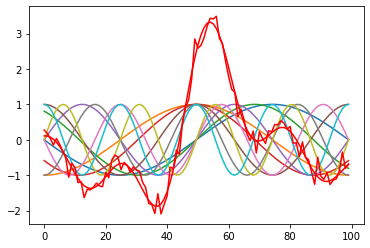

In [120]:
plt.plot(T);
plt.plot(obs0['x'], 'r')
plt.plot(obs1['x'], 'r')

In [121]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [122]:
class Head(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = 50
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([10000]))
        self.l1 = torch.nn.Linear(10000, 50)
        
    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        x = self.l1(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `Head`


In [130]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 20000)

In [ ]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

In [128]:
par0 = {k: np.random.rand() for k in param_names}
obs0 = model(par0)
obs1 = noise(obs0, par0)

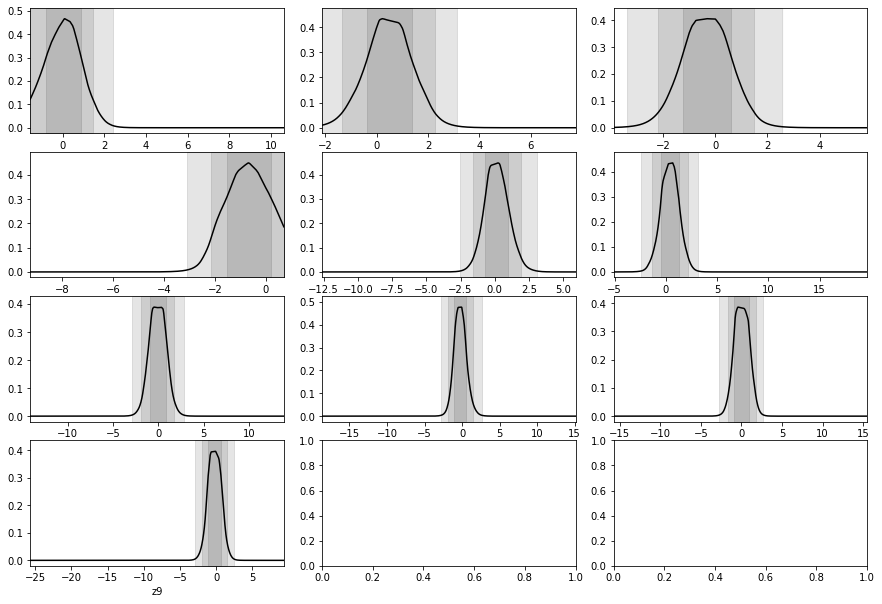

In [129]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]
swyft.plot1d(samples, param_names, ncol = 3, grid_interpolate = True)

### Conclusions
- Still, these posteriors look too narrow. Not entirely sure what is going on here.

### Test 3 - Small signal, huge noise, large data, more training data - smaller errors - much more training data

- I'll increase the amount of training data

In [132]:
g = np.linspace(-np.pi, np.pi, 100)
T = np.array([
    np.sin(g),
    np.cos(g),
    np.sin(g*1.3),
    np.cos(g*1.3),
    np.sin(g*2),
    np.cos(g*2),
    np.sin(g*3),
    np.cos(g*3),
    np.sin(g*4),
    np.cos(g*4),
]).T
#T = T[:,0:5]
sigma = 0.2
F = T.T.dot(T)/sigma**2
#plt.imshow(F)
Sigma = np.linalg.inv(F)
errors0 = np.diag(Sigma)**0.5
errors1 = np.diag(1/F)**0.5

C = np.diag(1/errors0).dot(Sigma.dot(np.diag(1/errors0)))
#plt.imshow(C)
#plt.colorbar()
print(errors0)
#print(errors1)
print(errors0/errors1)

[0.0820108  0.10141349 0.10303548 0.10033481 0.05399807 0.04043469
 0.0357779  0.02960147 0.03203128 0.02853791]
[2.88498554 3.60339126 3.43295564 3.7406164  1.89955053 1.43671231
 1.25859913 1.05178993 1.12680028 1.0139996 ]


In [133]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [134]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [135]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs1 = noise(obs0, par0)

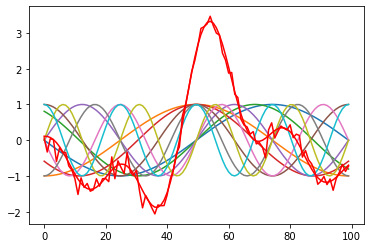

In [136]:
plt.plot(T);
plt.plot(obs0['x'], 'r')
plt.plot(obs1['x'], 'r')

In [137]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [138]:
class Head(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = 50
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([10000]))
        self.l1 = torch.nn.Linear(10000, 50)
        
    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        x = self.l1(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `Head`


In [139]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 100000)

In [140]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (100,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 100000


Creating new cache.


INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 24/100223 [00:00<07:11, 232.10it/s]

  adding 100223 new samples to simulator cache.


Simulate: 100%|██████████| 100223/100223 [07:06<00:00, 234.87it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([100])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(100, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 6.432
DEBUG:root:validation loss = 6.

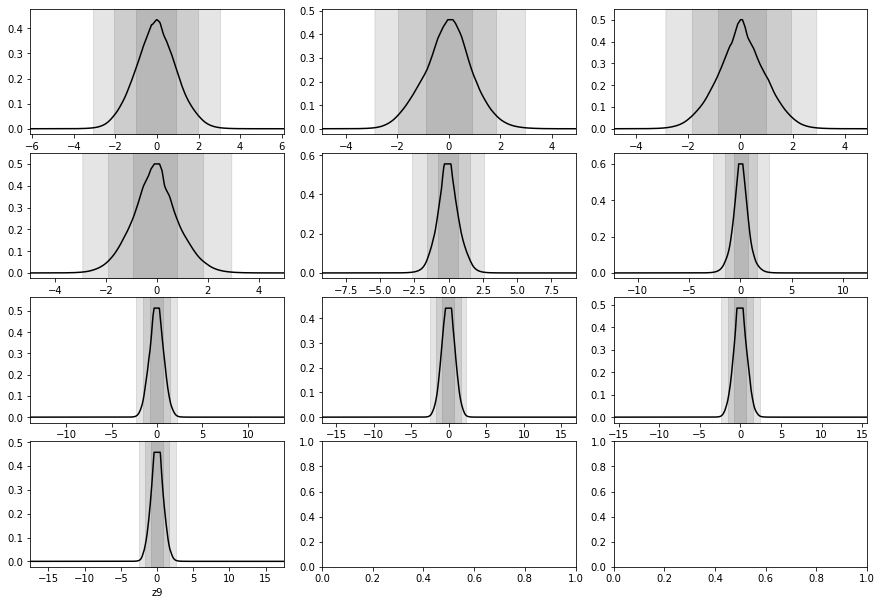

In [141]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]
swyft.plot1d(samples, param_names, ncol = 3, grid_interpolate = True)

### Conclusions
- Still, these posteriors look too narrow. Not entirely sure what is going on here.

In [128]:
par0 = {k: np.random.rand() for k in param_names}
obs0 = model(par0)
obs1 = noise(obs0, par0)